# Read Data

In [1]:
import pandas as pd
import os 
import glob
import numpy as np
from IPython.display import display

In [2]:
datasets = glob.glob(os.path.join("./Dataset", "*.csv"))

dataframes = {}
for file in datasets:
    name = os.path.splitext(os.path.basename(file))[0] 
    dataframes[name] = pd.read_csv(file)

In [3]:
member2 = dataframes['member_data']
program2 = dataframes['prodgram_data']
product2 = dataframes['product_data']
transaction_test2 = dataframes['test_transaction_data']
transaction_train2 = dataframes['train_transaction_data']
label2 = dataframes['train_label_data']

# Gabungin Tabel, Member-level

## 1. Merge: Transaction + Product + Prodgram

In [4]:
# samain nama primary key nya
transaction_test2.rename(columns={'FK_PRODUCT_ID': 'productID', 'FK_PROD_GRAM_ID': 'prodgramID'}, inplace=True)
transaction_train2.rename(columns={'FK_PRODUCT_ID': 'productID', 'FK_PROD_GRAM_ID': 'prodgramID'}, inplace=True)

# left join 
transaction_train2 = transaction_train2.merge(product2, on='productID', how='left')
transaction_train2 = transaction_train2.merge(program2, on='prodgramID', how='left')

transaction_test2 = transaction_test2.merge(product2, on='productID', how='left')
transaction_test2 = transaction_test2.merge(program2, on='prodgramID', how='left')

## 2. Aggregate Transaction per Member ID (train)

In [5]:
transaction_train2["TransactionDatetime"] = pd.to_datetime(transaction_train2["TransactionDatetime"]) # buat bikin fitur waktu
transaction_train2

,TransactionID,MemberID,Source,productID,prodgramID,Qty,PricePerUnit,TransactionDatetime,ProductName,ProductCategory,ProductLevel,GrammageName,Point,Price
0,ffd6c035bef03a2c386caf2552148fb2402b0b24,7ef72aa51aecb701dc5c4074480fcdf6,ELANG,27,52,1,NaN,2020-07-01 07:41:00+00:00,A,A,Original,700 GR,50,201000.0
1,4fadf10aff7e250cc8d63badeaefdf383c0e1c13,577f1b9a093c2cec6398b1118f5d99ab,ALFAMART,22,39,1,290000.0,2020-07-01 07:24:00+00:00,A G,A,Premium,900 GR,100,300000.0
2,7299df1aaf47b52017f58dd8e59df1fe37072670,e2ee74f248a74ed886a22f14348fbafd,EKTONG,22,39,1,263500.0,2020-07-01 09:13:00+00:00,A G,A,Premium,900 GR,100,300000.0
3,22dae0e1e8bb87601eabd712721bd249739bc620,cefa8ef7469a8b4e6df3f745d4905000,CITRA,27,52,3,145000.0,2020-07-01 08:28:00+00:00,A,A,Original,700 GR,50,201000.0
4,6a744d5d79e09b0c1646e604db1c4ec65eff73d7,5eecda17ddf06ed9d79f298b13f84785,INDOMARET,27,52,1,165900.0,2020-07-01 07:02:00+00:00,A,A,Original,700 GR,50,201000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130849,982e5420a08d52c10be889233bd40873f742509d,503495face9276840e23f770545ade30,SATU SAMA,22,39,1,263000.0,2021-06-30 13:46:00+00:00,A G,A,Premium,900 GR,100,300000.0
130850,8b161fcde975bbd1f1e861451a3dbfe6ab2fa502,ac2075bc561664d35deb6e4c7b55f680,INDOMARET,22,39,1,290500.0,2021-06-29 19:19:00+00:00,A G,A,Premium,900 GR,100,300000.0
130851,8820dceb01572c6ba82ce44a960ad226fc16008a,d315f435189a22e43ef2bcd5dd67281a,TOKO SUSUKU,22,39,4,261000.0,2021-06-05 16:11:00+00:00,A G,A,Premium,900 GR,100,300000.0
130852,8f8eb8268cdaffa34cbb9da522346fc7d5f53a9b,e3c4ceb8c70215f3a40d7314a255c17a,MURAH HEMAT,22,39,2,268000.0,2021-06-30 14:31:00+00:00,A G,A,Premium,900 GR,100,300000.0


ohh aman, meskipun Price dan GrammageName ada null, setelah di-join gaada null, brti emang di transaction_train gaada prodgramID yg null Price sama GrammageName nya. <br>
tipe data juga udah sesuai

In [6]:
transaction_train2["total_spent"] = transaction_train2["Qty"] * transaction_train2["PricePerUnit"]

transaction_train_agg2 = transaction_train2.groupby("MemberID").agg(
    num_transactions = ("TransactionID", "count"), # jumlah transaksi
    total_qty = ("Qty", "sum"), # total quantity
    avg_qty = ("Qty", "mean"), # rata-rata quantity
    total_spent = ("total_spent", "sum"), # total pengeluaran
    avg_spent = ("total_spent", "mean"), # rata-rata pengeluaran
    unique_products = ("productID", pd.Series.nunique), # jumlah produk unik
    unique_categories = ("ProductCategory", pd.Series.nunique), # jumlah kategori unik
    most_common_category = ("ProductCategory", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan), # kategori paling umum
    first_purchase = ("TransactionDatetime", "min"), # tanggal pembelian pertama
    last_purchase = ("TransactionDatetime", "max"), # tanggal pembelian terakhir
    unique_sources = ("Source", pd.Series.nunique), # jumlah sumber unik
    most_common_source = ("Source", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) # sumber paling umum
).reset_index()

## 3. Merge: Member + Transaction yg udah di-aggregate + Label

In [7]:
df_train2 = transaction_train_agg2.merge(member2, on="MemberID", how="left")
df_train2 = df_train2.merge(label2, on="MemberID", how="left")

In [8]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40020 entries, 0 to 40019
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   MemberID              40020 non-null  object             
 1   num_transactions      40020 non-null  int64              
 2   total_qty             40020 non-null  int64              
 3   avg_qty               40020 non-null  float64            
 4   total_spent           40020 non-null  float64            
 5   avg_spent             36284 non-null  float64            
 6   unique_products       40020 non-null  int64              
 7   unique_categories     40020 non-null  int64              
 8   most_common_category  40020 non-null  object             
 9   first_purchase        40020 non-null  datetime64[ns, UTC]
 10  last_purchase         40020 non-null  datetime64[ns, UTC]
 11  unique_sources        40020 non-null  int64              
 12  most

In [9]:
df_train2['MemberID'].nunique()

40020

# Feature Engineering

In [10]:
datetime_cols = ['first_purchase','last_purchase','JoinDate','DateOfBirth','EldestKidDOB','YoungestKidDOB']
for col in datetime_cols:
    df_train2[col] = pd.to_datetime(df_train2[col], errors='coerce').dt.tz_localize(None)

# Also make reference date tz-naive
reference_date2 = pd.to_datetime(df_train2['last_purchase'].max()).tz_localize(None)

In [11]:
df_train2['days_since_last_purchase'] = (reference_date2 - df_train2['last_purchase']).dt.days
df_train2['days_since_first_purchase'] = (reference_date2 - df_train2['first_purchase']).dt.days
df_train2['purchase_duration'] = (df_train2['last_purchase'] - df_train2['first_purchase']).dt.days

df_train2['membership_duration'] = (reference_date2 - df_train2['JoinDate']).dt.days
df_train2['youngest_kid_age'] = (reference_date2 - df_train2['YoungestKidDOB']).dt.days
df_train2['eldest_kid_age'] = (reference_date2 - df_train2['EldestKidDOB']).dt.days

df_train2['join_month'] = df_train2['JoinDate'].dt.month
df_train2['join_year'] = df_train2['JoinDate'].dt.year

In [12]:
df_train2 = df_train2.drop(columns=datetime_cols)

In [13]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40020 entries, 0 to 40019
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MemberID                   40020 non-null  object 
 1   num_transactions           40020 non-null  int64  
 2   total_qty                  40020 non-null  int64  
 3   avg_qty                    40020 non-null  float64
 4   total_spent                40020 non-null  float64
 5   avg_spent                  36284 non-null  float64
 6   unique_products            40020 non-null  int64  
 7   unique_categories          40020 non-null  int64  
 8   most_common_category       40020 non-null  object 
 9   unique_sources             40020 non-null  int64  
 10  most_common_source         40020 non-null  object 
 11  City                       40020 non-null  object 
 12  NoOfChild                  40020 non-null  int64  
 13  next_buy                   40020 non-null  int

# Preprocess Test Data

In [14]:
transaction_test2["TransactionDatetime"] = pd.to_datetime(transaction_test2["TransactionDatetime"]) # buat bikin fitur waktu
transaction_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   TransactionID        21098 non-null  object             
 1   MemberID             21098 non-null  object             
 2   Source               21098 non-null  object             
 3   productID            21098 non-null  int64              
 4   prodgramID           21098 non-null  int64              
 5   Qty                  21098 non-null  int64              
 6   PricePerUnit         17917 non-null  float64            
 7   TransactionDatetime  21098 non-null  datetime64[ns, UTC]
 8   ProductName          21098 non-null  object             
 9   ProductCategory      21098 non-null  object             
 10  ProductLevel         21098 non-null  object             
 11  GrammageName         21098 non-null  object             
 12  Point             

In [15]:
transaction_test2["total_spent"] = transaction_test2["Qty"] * transaction_test2["PricePerUnit"]

transaction_test_agg2 = transaction_test2.groupby("MemberID").agg(
    num_transactions = ("TransactionID", "count"), # jumlah transaksi
    total_qty = ("Qty", "sum"), # total quantity
    avg_qty = ("Qty", "mean"), # rata-rata quantity
    total_spent = ("total_spent", "sum"), # total pengeluaran
    avg_spent = ("total_spent", "mean"), # rata-rata pengeluaran
    unique_products = ("productID", pd.Series.nunique), # jumlah produk unik
    unique_categories = ("ProductCategory", pd.Series.nunique), # jumlah kategori unik
    most_common_category = ("ProductCategory", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan), # kategori paling umum
    first_purchase = ("TransactionDatetime", "min"), # tanggal pembelian pertama
    last_purchase = ("TransactionDatetime", "max"), # tanggal pembelian terakhir
    unique_sources = ("Source", pd.Series.nunique), # jumlah sumber unik
    most_common_source = ("Source", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) # sumber paling umum
).reset_index()

In [16]:
df_test2 = transaction_test_agg2.merge(member2, on="MemberID", how="left")

In [17]:
for col in datetime_cols:
    df_test2[col] = pd.to_datetime(df_test2[col], errors='coerce').dt.tz_localize(None)

In [18]:
df_test2['days_since_last_purchase'] = (reference_date2 - df_test2['last_purchase']).dt.days
df_test2['days_since_first_purchase'] = (reference_date2 - df_test2['first_purchase']).dt.days
df_test2['purchase_duration'] = (df_test2['last_purchase'] - df_test2['first_purchase']).dt.days

df_test2['membership_duration'] = (reference_date2 - df_test2['JoinDate']).dt.days
df_test2['youngest_kid_age'] = (reference_date2 - df_test2['YoungestKidDOB']).dt.days
df_test2['eldest_kid_age'] = (reference_date2 - df_test2['EldestKidDOB']).dt.days

df_test2['join_month'] = df_test2['JoinDate'].dt.month
df_test2['join_year'] = df_test2['JoinDate'].dt.year

df_test2 = df_test2.drop(columns=datetime_cols)

# Modeling

In [19]:
train = df_train2.copy()
test = df_test2.copy()

In [20]:
# train = pd.read_csv('memberlevel.csv')
# test = pd.read_csv('memberlevel_test.csv')

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

X = train.drop(['MemberID', 'next_buy'], axis=1)
y = train['next_buy']

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = [col for col in X.columns if col not in numeric_cols]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [22]:
X_preprocessed = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

In [23]:
X_test = test.drop(['MemberID'], axis=1)

X_test_preprocessed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

### check similarity

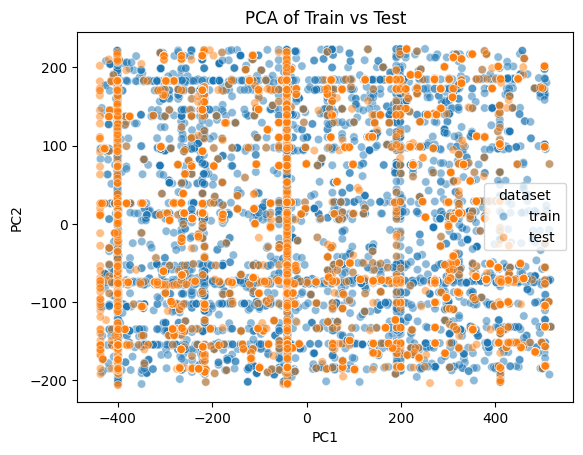

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_combined = pd.concat([X_preprocessed, X_test_preprocessed])
X_combined = X_combined.fillna(X_combined.median(numeric_only=True))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['dataset'] = ['train'] * len(X_preprocessed) + ['test'] * len(X_test_preprocessed)

sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='dataset', alpha=0.5)
plt.title('PCA of Train vs Test')
plt.show()

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X_all = pd.concat([X_preprocessed, X_test_preprocessed])
y_domain = [0]*len(X_preprocessed) + [1]*len(X_test_preprocessed)

model = XGBClassifier(n_estimators=100)
model.fit(X_all, y_domain)

print("AUC (train vs test classifier):", roc_auc_score(y_domain, model.predict_proba(X_all)[:,1]))

AUC (train vs test classifier): 0.8521577911874654


In [26]:
train_vs_test_model = XGBClassifier(n_estimators=100, random_state=42)
train_vs_test_model.fit(X_all, y_domain)

train_probs = train_vs_test_model.predict_proba(X_preprocessed)[:, 1]

In [ ]:
import numpy as np

# 1. Combine preprocessed train and test data
X_all = pd.concat([X_preprocessed, X_test_preprocessed])
y_domain = [0]*len(X_preprocessed) + [1]*len(X_test_preprocessed)

# 2. Train domain classifier
from xgboost import XGBClassifier
domain_clf = XGBClassifier(n_estimators=100, random_state=42)
domain_clf.fit(X_all, y_domain)

# 3. Get predicted probability that train rows look like test
train_probs = domain_clf.predict_proba(X_preprocessed)[:, 1]  

# Separate based on labels
X_pos = X_preprocessed[y == 1]
X_neg = X_preprocessed[y == 0]
probs_pos = train_probs[y == 1]
probs_neg = train_probs[y == 0]

# Thresholds
pos_thresh = np.percentile(probs_pos, 10)  # Keep top 90% of positives
neg_thresh = np.percentile(probs_neg, 70)  # Keep top 30% of negatives

# Masks
keep_pos = probs_pos >= pos_thresh
keep_neg = probs_neg >= neg_thresh

# Filtered sets
X_pos_filtered = X_pos[keep_pos]
X_neg_filtered = X_neg[keep_neg]
y_pos_filtered = y[y == 1][keep_pos]
y_neg_filtered = y[y == 0][keep_neg]

# Final filtered train set
X_filtered = pd.concat([X_pos_filtered, X_neg_filtered])
y_filtered = pd.concat([y_pos_filtered, y_neg_filtered])

print("Filtered train size:", len(X_filtered))
print("Class balance: %.2f%% positive" % (100 * y_filtered.mean()))

Filtered train size: 13469
Class balance: 16.29% positive


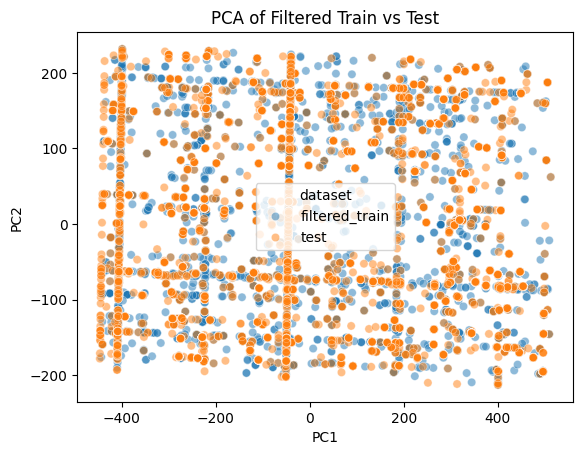

In [ ]:
X_check = pd.concat([X_filtered, X_test_preprocessed])
X_check = X_check.fillna(X_check.median(numeric_only=True))

# Run PCA
pca = PCA(n_components=2)
X_check_pca = pca.fit_transform(X_check)

df_plot = pd.DataFrame(X_check_pca, columns=['PC1', 'PC2'])
df_plot['dataset'] = ['filtered_train'] * len(X_filtered) + ['test'] * len(X_test_preprocessed)

sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='dataset', alpha=0.5)
plt.title('PCA of Filtered Train vs Test')
plt.show()

In [59]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_filtered[['cat__most_common_source', 'cat__City']], y_filtered)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
prediction = model.predict(X_test_preprocessed[['cat__most_common_source', 'cat__City']])

submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': prediction
})

submission.to_csv('trial40.csv', index=False)